# CNN + MaxPool
Previously, reducing num conv filters improved MCC. Here, reduce num conv layers.

In [13]:
from datetime import datetime
print(datetime.now())

2023-03-21 16:00:55.931228


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    #cnn.add(cnn3_layer)
    #cnn.add(cnn4_layer)
    #cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 16:00:58.728720
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_44 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 conv1d_45 (Conv1D)          (None, 4983, 64)          32832     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 1244, 64)         0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 79616)             0         
                                                                 
 dropout_11 (Dropout)        (None, 79616)             0         
                          

## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 16:00:58.929205
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 16:01:04.966911

Training # 1 1
2023-03-21 16:01:04.967272
2023-03-21 16:01:04.967326
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 16:01:06.187294


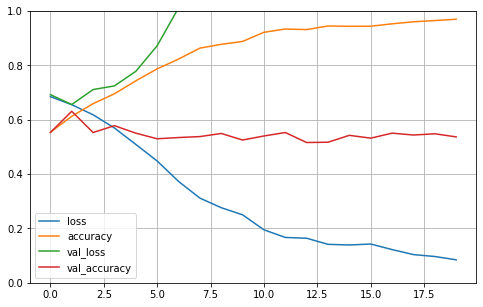


2023-03-21 16:02:29.896600

Testing # 1 1
2023-03-21 16:02:29.896708
2023-03-21 16:02:29.896747
PREDICT
2023-03-21 16:02:30.106293
Test 1:0 458:412 52.64%
Predict 1:0 425:445 48.85%
Test sizes (870, 4997) (870,)
Range of scores: 1.4320809e-12 to 1.0
Score threshold 0.5
Confusion matrix
 [[227 185]
 [218 240]]
Normalized matrix
 [[0.26091954 0.21264368]
 [0.25057471 0.27586207]]


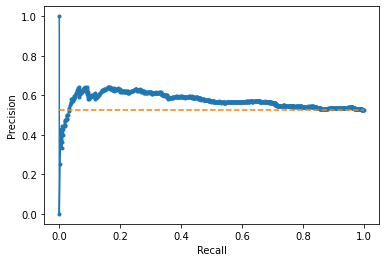

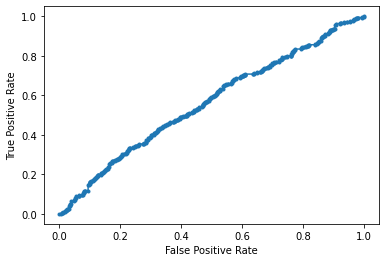

Accuracy: 53.68% Precision: 56.47% Recall: 52.40%
F1: 54.36% MCC: 0.0749
AUPRC: 57.22% AUROC: 56.30%
 accuracy [53.67816091954023]
 precision [56.470588235294116]
 recall [52.40174672489083]
 F1 [54.36013590033974]
 MCC [0.07490324318427512]
 AUPRC [57.22438131199635]
 AUROC [56.30008055284692]
2023-03-21 16:02:30.852183

Training # 1 2
2023-03-21 16:02:30.852314
2023-03-21 16:02:30.852356
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 16:02:32.048632


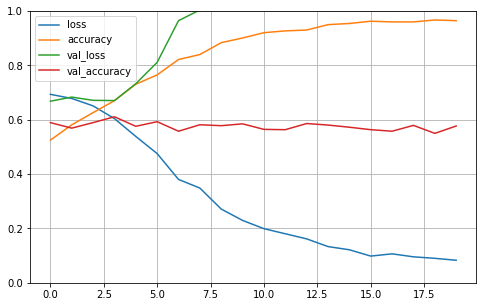


2023-03-21 16:03:23.737259

Testing # 1 2
2023-03-21 16:03:23.737357
2023-03-21 16:03:23.737393
PREDICT
2023-03-21 16:03:23.960469
Test 1:0 442:442 50.00%
Predict 1:0 456:428 51.58%
Test sizes (884, 4997) (884,)
Range of scores: 6.503954e-14 to 1.0
Score threshold 0.5
Confusion matrix
 [[248 194]
 [180 262]]
Normalized matrix
 [[0.28054299 0.21945701]
 [0.20361991 0.29638009]]


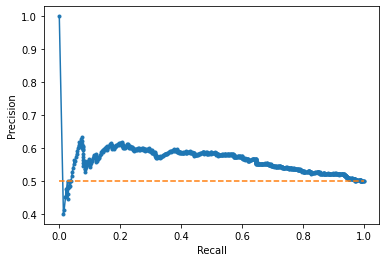

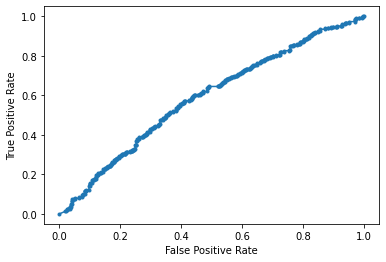

Accuracy: 57.69% Precision: 57.46% Recall: 59.28%
F1: 58.35% MCC: 0.1539
AUPRC: 56.32% AUROC: 58.83%
 accuracy [57.692307692307686]
 precision [57.45614035087719]
 recall [59.276018099547514]
 F1 [58.35189309576837]
 MCC [0.15392338546033993]
 AUPRC [56.320815116987745]
 AUROC [58.82915992711042]
2023-03-21 16:03:24.766350

Training # 1 3
2023-03-21 16:03:24.766483
2023-03-21 16:03:24.766532
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 16:03:25.930632


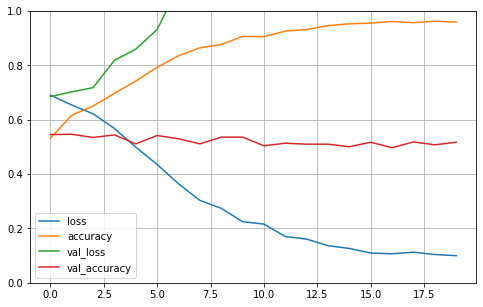


2023-03-21 16:04:49.143862

Testing # 1 3
2023-03-21 16:04:49.145484
2023-03-21 16:04:49.145853
PREDICT
2023-03-21 16:04:49.549534
Test 1:0 442:407 52.06%
Predict 1:0 520:329 61.25%
Test sizes (849, 4997) (849,)
Range of scores: 1.6629818e-10 to 1.0
Score threshold 0.5
Confusion matrix
 [[163 244]
 [166 276]]
Normalized matrix
 [[0.19199058 0.28739694]
 [0.19552415 0.32508834]]


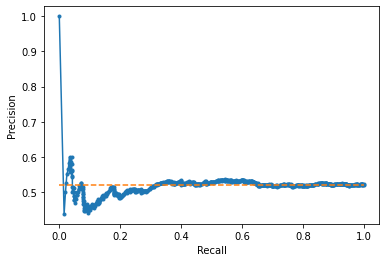

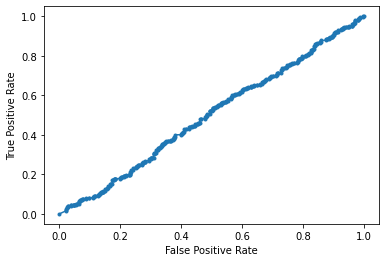

Accuracy: 51.71% Precision: 53.08% Recall: 62.44%
F1: 57.38% MCC: 0.0256
AUPRC: 51.93% AUROC: 50.01%
 accuracy [51.70789163722026]
 precision [53.07692307692308]
 recall [62.44343891402715]
 F1 [57.380457380457386]
 MCC [0.025559811335544604]
 AUPRC [51.9264275449275]
 AUROC [50.006948536360305]
2023-03-21 16:04:50.474122

Training # 1 4
2023-03-21 16:04:50.475837
2023-03-21 16:04:50.476230
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 16:04:52.178308


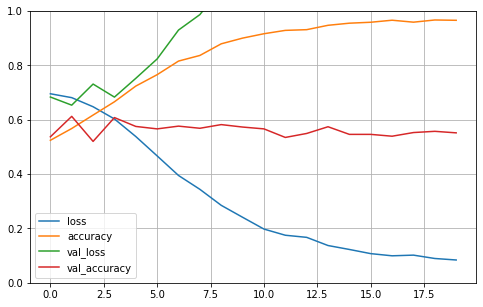


2023-03-21 16:06:15.308718

Testing # 1 4
2023-03-21 16:06:15.308809
2023-03-21 16:06:15.308844
PREDICT
2023-03-21 16:06:15.528028
Test 1:0 459:431 51.57%
Predict 1:0 468:422 52.58%
Test sizes (890, 4997) (890,)
Range of scores: 1.2506988e-13 to 1.0
Score threshold 0.5
Confusion matrix
 [[227 204]
 [195 264]]
Normalized matrix
 [[0.25505618 0.22921348]
 [0.21910112 0.29662921]]


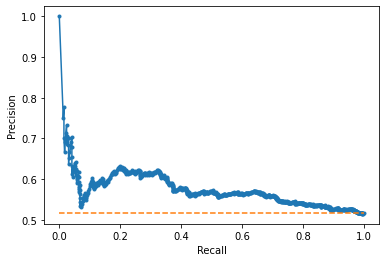

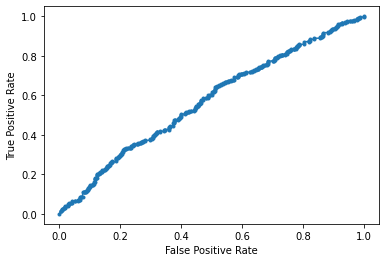

Accuracy: 55.17% Precision: 56.41% Recall: 57.52%
F1: 56.96% MCC: 0.1019
AUPRC: 57.64% AUROC: 57.09%
 accuracy [55.168539325842694]
 precision [56.41025641025641]
 recall [57.51633986928104]
 F1 [56.957928802588995]
 MCC [0.10193135849217498]
 AUPRC [57.64273009593733]
 AUROC [57.091983480682806]
2023-03-21 16:06:16.267336

Training # 1 5
2023-03-21 16:06:16.267466
2023-03-21 16:06:16.267515
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 16:06:17.447258


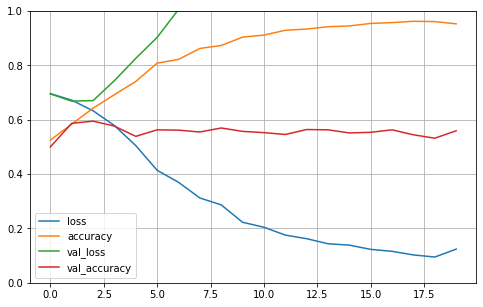


2023-03-21 16:07:40.747072

Testing # 1 5
2023-03-21 16:07:40.747179
2023-03-21 16:07:40.747218
PREDICT
2023-03-21 16:07:40.970150
Test 1:0 457:419 52.17%
Predict 1:0 431:445 49.20%
Test sizes (876, 4997) (876,)
Range of scores: 1.3739107e-15 to 1.0
Score threshold 0.5
Confusion matrix
 [[239 180]
 [206 251]]
Normalized matrix
 [[0.27283105 0.20547945]
 [0.23515982 0.28652968]]


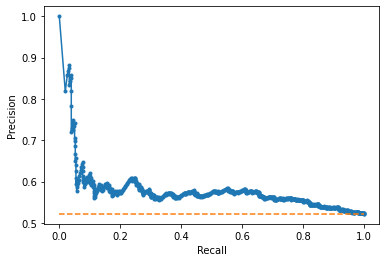

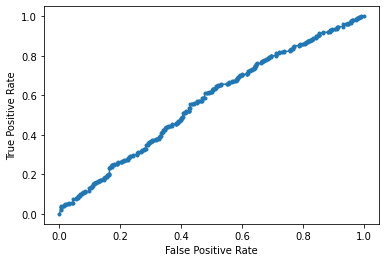

Accuracy: 55.94% Precision: 58.24% Recall: 54.92%
F1: 56.53% MCC: 0.1195
AUPRC: 58.13% AUROC: 56.67%
 accuracy [55.93607305936074]
 precision [58.23665893271461]
 recall [54.92341356673961]
 F1 [56.53153153153152]
 MCC [0.11954251269459402]
 AUPRC [58.131655356451276]
 AUROC [56.66508253996439]
2023-03-21 16:07:41.757884

Training # 2 1
2023-03-21 16:07:41.758020
2023-03-21 16:07:41.758068
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 16:07:42.940004


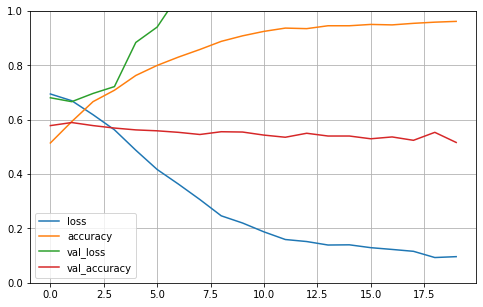


2023-03-21 16:09:06.826665

Testing # 2 1
2023-03-21 16:09:06.828197
2023-03-21 16:09:06.828510
PREDICT
2023-03-21 16:09:07.239109
Test 1:0 472:415 53.21%
Predict 1:0 531:356 59.86%
Test sizes (887, 4997) (887,)
Range of scores: 1.8468308e-13 to 1.0
Score threshold 0.5
Confusion matrix
 [[171 244]
 [185 287]]
Normalized matrix
 [[0.19278467 0.27508455]
 [0.20856821 0.32356257]]


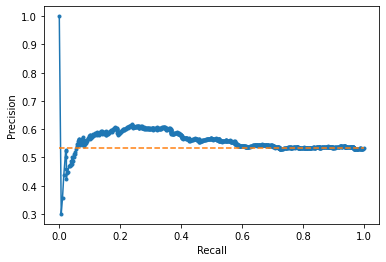

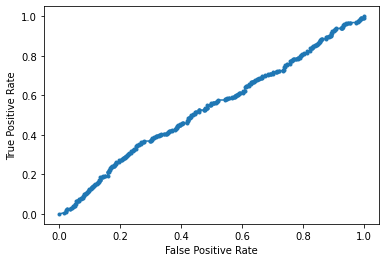

Accuracy: 51.63% Precision: 54.05% Recall: 60.81%
F1: 57.23% MCC: 0.0205
AUPRC: 55.74% AUROC: 53.34%
 accuracy [51.634723788049605]
 precision [54.048964218455744]
 recall [60.80508474576271]
 F1 [57.22831505483549]
 MCC [0.02045964564502005]
 AUPRC [55.738633666603285]
 AUROC [53.342607719011646]
2023-03-21 16:09:08.130542

Training # 2 2
2023-03-21 16:09:08.130690
2023-03-21 16:09:08.130737
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 16:09:09.297215


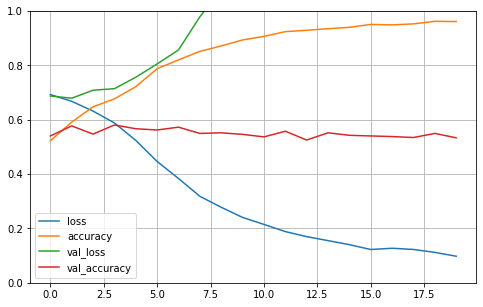


2023-03-21 16:10:32.508266

Testing # 2 2
2023-03-21 16:10:32.508740
2023-03-21 16:10:32.508778
PREDICT
2023-03-21 16:10:32.736935
Test 1:0 452:416 52.07%
Predict 1:0 465:403 53.57%
Test sizes (868, 4997) (868,)
Range of scores: 4.828459e-12 to 1.0
Score threshold 0.5
Confusion matrix
 [[207 209]
 [196 256]]
Normalized matrix
 [[0.23847926 0.24078341]
 [0.22580645 0.29493088]]


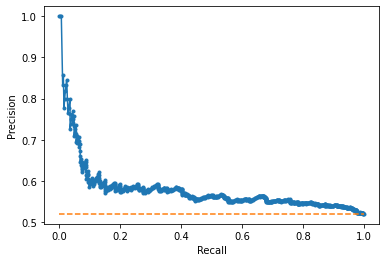

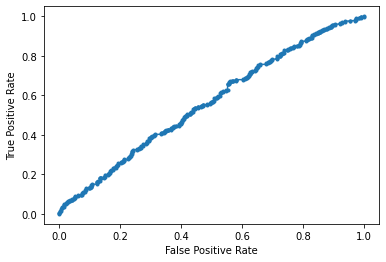

Accuracy: 53.34% Precision: 55.05% Recall: 56.64%
F1: 55.83% MCC: 0.0641
AUPRC: 57.97% AUROC: 56.24%
 accuracy [53.3410138248848]
 precision [55.053763440860216]
 recall [56.63716814159292]
 F1 [55.83424209378407]
 MCC [0.0640764639399562]
 AUPRC [57.97370476956005]
 AUROC [56.2380339516678]
2023-03-21 16:10:33.546130

Training # 2 3
2023-03-21 16:10:33.547275
2023-03-21 16:10:33.547327
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 16:10:34.995403


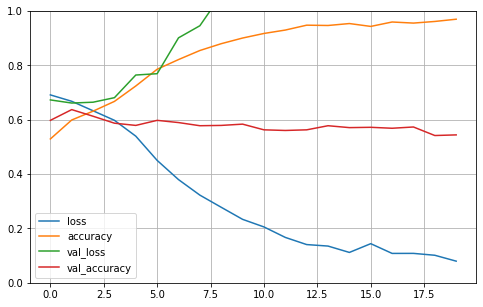


2023-03-21 16:11:58.590725

Testing # 2 3
2023-03-21 16:11:58.590825
2023-03-21 16:11:58.590860
PREDICT
2023-03-21 16:11:58.799927
Test 1:0 453:407 52.67%
Predict 1:0 387:473 45.00%
Test sizes (860, 4997) (860,)
Range of scores: 1.8612668e-12 to 1.0
Score threshold 0.5
Confusion matrix
 [[244 163]
 [229 224]]
Normalized matrix
 [[0.28372093 0.18953488]
 [0.26627907 0.26046512]]


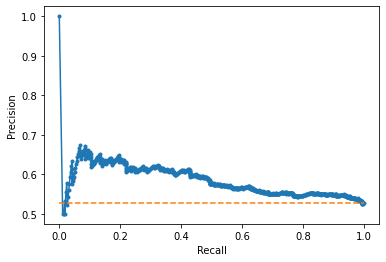

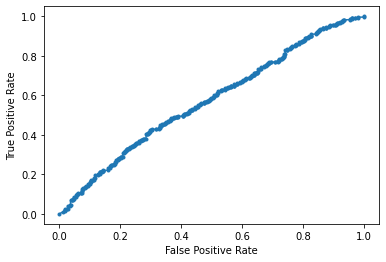

Accuracy: 54.42% Precision: 57.88% Recall: 49.45%
F1: 53.33% MCC: 0.0943
AUPRC: 58.59% AUROC: 57.27%
 accuracy [54.418604651162795]
 precision [57.88113695090439]
 recall [49.448123620309055]
 F1 [53.333333333333336]
 MCC [0.09432811226211539]
 AUPRC [58.58682235322558]
 AUROC [57.272835749656934]
2023-03-21 16:11:59.548123

Training # 2 4
2023-03-21 16:11:59.548255
2023-03-21 16:11:59.548299
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 16:12:00.717471


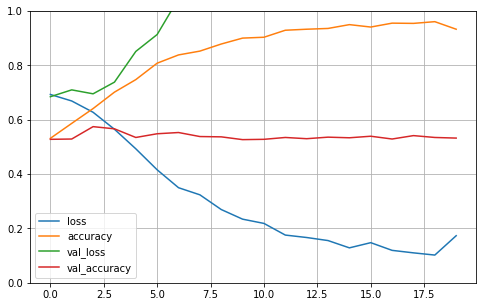


2023-03-21 16:12:53.335421

Testing # 2 4
2023-03-21 16:12:53.335720
2023-03-21 16:12:53.335758
PREDICT
2023-03-21 16:12:53.555063
Test 1:0 432:447 49.15%
Predict 1:0 489:390 55.63%
Test sizes (879, 4997) (879,)
Range of scores: 7.561949e-14 to 1.0
Score threshold 0.5
Confusion matrix
 [[213 234]
 [177 255]]
Normalized matrix
 [[0.24232082 0.2662116 ]
 [0.20136519 0.29010239]]


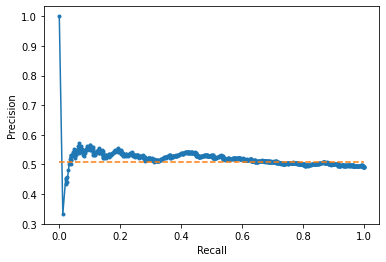

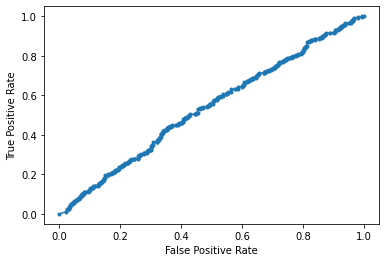

Accuracy: 53.24% Precision: 52.15% Recall: 59.03%
F1: 55.37% MCC: 0.0672
AUPRC: 52.00% AUROC: 53.91%
 accuracy [53.242320819112635]
 precision [52.14723926380368]
 recall [59.02777777777778]
 F1 [55.37459283387622]
 MCC [0.06720573448042183]
 AUPRC [51.99538487442042]
 AUROC [53.90903347419007]
2023-03-21 16:12:54.296923

Training # 2 5
2023-03-21 16:12:54.297281
2023-03-21 16:12:54.297326
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 16:12:55.456146


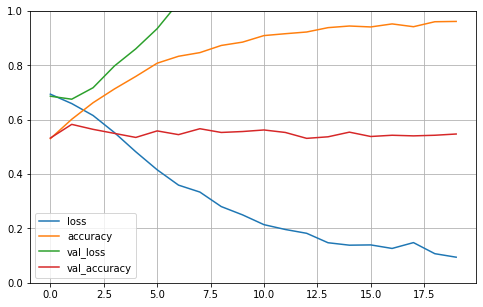


2023-03-21 16:14:18.627703

Testing # 2 5
2023-03-21 16:14:18.627807
2023-03-21 16:14:18.627845
PREDICT
2023-03-21 16:14:18.855440
Test 1:0 449:426 51.31%
Predict 1:0 489:386 55.89%
Test sizes (875, 4997) (875,)
Range of scores: 8.731128e-12 to 1.0
Score threshold 0.5
Confusion matrix
 [[208 218]
 [178 271]]
Normalized matrix
 [[0.23771429 0.24914286]
 [0.20342857 0.30971429]]


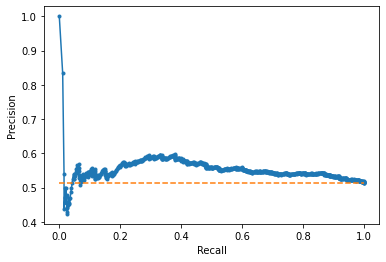

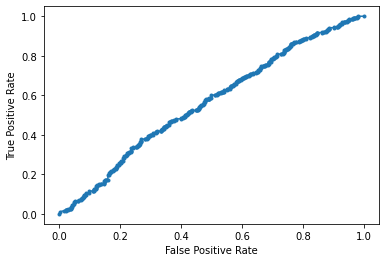

Accuracy: 54.74% Precision: 55.42% Recall: 60.36%
F1: 57.78% MCC: 0.0924
AUPRC: 55.50% AUROC: 56.31%
 accuracy [54.74285714285714]
 precision [55.419222903885476]
 recall [60.35634743875279]
 F1 [57.78251599147121]
 MCC [0.0924373265612587]
 AUPRC [55.50231346927204]
 AUROC [56.3147631146941]
2023-03-21 16:14:19.594288


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.16% std 1.86
 precision mean 55.62% std 2.06
 recall mean 57.28% std 4.04
 F1 mean 56.31% std 1.58
 MCC mean 0.08% std 0.04
 AUPRC mean 56.10% std 2.41
 AUROC mean 55.60% std 2.52
 accuracy [[53.67816091954023], [57.692307692307686], [51.70789163722026], [55.168539325842694], [55.93607305936074], [51.634723788049605], [53.3410138248848], [54.418604651162795], [53.242320819112635], [54.74285714285714]]
 precision [[56.470588235294116], [57.45614035087719], [53.07692307692308], [56.41025641025641], [58.23665893271461], [54.048964218455744], [55.053763440860216], [57.88113695090439], [52.14723926380368], [55.419222903885476]]
 recall [[52.40174672489083], [59.276018099547514], [62.44343891402715], [57.51633986928104], [54.92341356673961], [60.80508474576271], [56.63716814159292], [49.448123620309055], [59.02777777777778], [60.35634743875279]]
 F1 [[54.36013590033974], [58.35189309576837], [57.380457380457386], [56.957928802588995], [56.53153153153152], [57.22831505483549